## Recurrent Neural Network with LSTM

Epoch 1/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2989
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1964
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0927
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0218
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0221
Epoch 6/50
5/5 [==============================] - 0s 42ms/step - loss: 0.0221
Epoch 7/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0087
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0109
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0083
Epoch 11/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0069
Epoch 12/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0066
Epoch 13/50
5/5 [==============================] - 0s 17ms/st

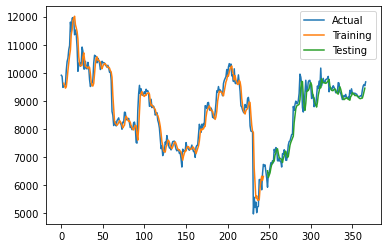

In [1]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Activation, Dense, Dropout
import pandas as pd
import numpy
import keras
import math
from keras import optimizers
from pandas import Series

data=pd.read_csv('BTC-USD.csv')
data=data.set_index(pd.DatetimeIndex(data['Date']))['Close']


def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

look_back=3
#data=difference(data,look_back)
#def project(data,look_back):
    #convert an array of values into a dataset matrix
    
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(0)

# loading dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalizing dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into Y=t+1 and X=t
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print(ans, [look_back,trainScore,testScore])

#return ans,[look_back,trainScore,testScore]

#   shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#   shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
#   plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Training')
plt.plot(testPredictPlot, label='Testing')
plt.legend()
plt.show()

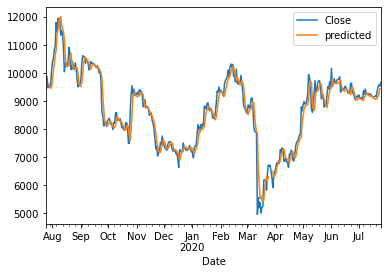

In [2]:
ans.plot()